In [1]:
import sys
import os
import random
import pickle
import numpy as np
from preprocessing import make_delayed
from preprocessing import downsample_word_vectors
import torch
from transformers import BertTokenizerFast, BertModel
from embeddings import make_word_dict, make_word_embeddings

# Add the root project folder to sys.path (so ridge_utils becomes importable)
project_root = os.path.abspath('..')  # moves up from 'code/'
sys.path.append(project_root)

# Load the raw_text.pkl file
path_to_data = '../data'
with open(f'{path_to_data}/raw_text.pkl', 'rb') as f:
    raw_text = pickle.load(f)


In [2]:
all_stories = list(raw_text.keys())
exclude = ['dialogue1',
 'dialogue2',
 'dialogue3',
 'dialogue4',
 'dialogue5',
 'dialogue6',
 'myfirstdaywiththeyankees',
 'onlyonewaytofindout']
valid_stories = [story for story in all_stories if story not in exclude]

In [3]:
all_stories = valid_stories
random.seed(42)
random.shuffle(all_stories)
split_idx = int(0.7 * len(all_stories))  # 70% for training

train_stories = all_stories[:split_idx]
test_stories = all_stories[split_idx:]

print(f"Train stories: {len(train_stories)}")
print(f"Test stories: {len(test_stories)}")
train_stories.sort()
test_stories.sort()

Train stories: 70
Test stories: 31


In [4]:
# dictonaries for train stories
story_vectors_bert = {} 
story_vectors_bert = make_word_dict(train_stories, raw_text)

In [5]:
wordseqs = {story: raw_text[story] for story in train_stories}
downsampled_vectors_bert = downsample_word_vectors(
    stories=train_stories,
    word_vectors=story_vectors_bert,
    wordseqs=wordseqs
)
trimmed_vectors_bert = {} #trimmed matrices for each train story 

for story, matrix in downsampled_vectors_bert.items():
    trimmed_matrix = matrix[5:-10]
    trimmed_vectors_bert[story] = trimmed_matrix

delayed_vectors_bert = {}

for story, trimmed_matrix in trimmed_vectors_bert.items():
    X_lagged = make_delayed(trimmed_matrix, delays=[1, 2, 3, 4])
    delayed_vectors_bert[story] = X_lagged

# check for first trimmed,delayed matrix, which corresponds to first story
for key, value in delayed_vectors_bert.items():
    print("First key:", key)
    print("delayed matrix for first story is", value.shape)
    break

First key: adollshouse
delayed matrix for first story is (241, 3072)


In [6]:
# dictionaries for test stories
story_vectors_bert_test = {}
story_vectors_bert_test = make_word_dict(test_stories, raw_text)

In [7]:
wordseqs2 = {story: raw_text[story] for story in test_stories}
downsampled_vectors_bert_test = downsample_word_vectors(
    stories=test_stories,
    word_vectors=story_vectors_bert_test,
    wordseqs=wordseqs2
)
trimmed_vectors_bert_test = {} #trimmed matrices for each test story 
for story, matrix in downsampled_vectors_bert_test.items():
    trimmed_matrix = matrix[5:-10]
    trimmed_vectors_bert_test[story] = trimmed_matrix

delayed_vectors_bert_test = {}
for story, trimmed_matrix in trimmed_vectors_bert_test.items():
    X_lagged = make_delayed(trimmed_matrix, delays=[1, 2, 3, 4])
    delayed_vectors_bert_test[story] = X_lagged
print(len(delayed_vectors_bert_test))

31


In [8]:
import gc
#del raw_text
gc.collect()

0

Ridge Regression - subject 2

In [9]:
from ridge_utils.ridge import ridge_corr, ridge_corr_pred
import numpy as np
import logging
from ridge_utils.ridge import ridge_corr
from ridge_utils.utils import mult_diag
import random
from sklearn.model_selection import KFold

In [10]:
path_s2 = '/ocean/projects/mth240012p/shared/data/subject2/'
Y_s2_train_dict = {}
for story in train_stories:
    Y_s2_train_dict[story] = np.load(path_s2 + f"{story}.npy")
Y_s2_test_dict = {}
for story in test_stories:
    Y_s2_test_dict[story] = np.load(path_s2 + f"{story}.npy")

In [11]:
#Test for bert, subject 2
# Stack X to make matrix
X_train_full = np.vstack([delayed_vectors_bert[s] for s in train_stories]) 
X_test_full = np.vstack([delayed_vectors_bert_test[s] for s in test_stories])    

# Stack Y2 to make one matrix
Y_train_s2 = np.vstack([Y_s2_train_dict[s] for s in train_stories])
Y_test_s2 = np.vstack([Y_s2_test_dict[s] for s in test_stories])

In [12]:
logging.basicConfig(level=logging.INFO)
ridge_logger = logging.getLogger("ridge_corr")
zs = lambda v: (v - v.mean(0)) / v.std(0)

X_train_full = zs(X_train_full)
X_test_full = zs(X_test_full)
Y_train_s2 = zs(Y_train_s2)
Y_test_s2 = zs(Y_test_s2)

In [13]:
# when alphas are all 1.
#subject 2
num_vox_s2 = 94251
corr_s2 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s2, Y_test_s2, valphas= np.ones(num_vox_s2))
mean_cc_2 = np.mean(corr_s2[np.isfinite(corr_s2)]) #exclude
print("Mean CC for sub2:", mean_cc_2)

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23810, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2306.696
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan


Mean CC for sub2: 0.010363654864144402


CV - 5 fold

In [14]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# 5-fold cross-validation on training stories
kf = KFold(n_splits=5, shuffle=True, random_state=42)
alphas = np.logspace(1, 4, 10)  # 10 values from 10 to 10000
Rcorrs_folds = []  # Store Rcorrs for each fold

for fold, (train_idx, val_idx) in enumerate(kf.split(train_stories)):
    print(f"Processing fold {fold + 1}/5 for bert")

    # Get the story names for this fold
    train = [train_stories[i] for i in train_idx]  # 56 stories
    val = [train_stories[i] for i in val_idx]      # 14 stories

    # Stack X and Y for this fold
    X_train = np.vstack([delayed_vectors_bert[s] for s in train]) 
    X_val = np.vstack([delayed_vectors_bert[s] for s in val])      
    Y_train = np.vstack([Y_s2_train_dict[s] for s in train])    
    Y_val = np.vstack([Y_s2_train_dict[s] for s in val])       

    # Z-score 
    X_train = zs(X_train)
    X_val = zs(X_val)
    Y_train = zs(Y_train)
    Y_val = zs(Y_val)

    # Run ridge_corr on this fold
    Rcorrs = ridge_corr(X_train, X_val, Y_train, Y_val, alphas, use_corr=True)
    Rcorrs = np.array(Rcorrs)  # (10, 94251)
    Rcorrs_folds.append(Rcorrs)

# Average Rcorrs across folds
Rcorrs_folds = np.array(Rcorrs_folds)  # (5, 10, 94251)
Rcorrs_5foldmean = Rcorrs_folds.mean(axis=0)  # (10, 94251)
# Select best alpha for each voxel
best_alpha_idx_s2 = np.argmax(Rcorrs_5foldmean, axis=0)  # (94251,)
valphas_s2 = alphas[best_alpha_idx_s2]  # (94251,)


Processing fold 1/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19290, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2066.908
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00899, max corr=0.13314, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00960, max corr=0.13869, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01115, max corr=0.15646, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01399, max corr=0.17950, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01792, max corr=0.19432, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02152, max corr=0.18976, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.02242, max corr=0.17238, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.02091, max corr=0.15973, over-und

Processing fold 2/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18621, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2056.302
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00789, max corr=0.11167, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00863, max corr=0.11572, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01052, max corr=0.12545, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01370, max corr=0.14704, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01774, max corr=0.17003, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02114, max corr=0.17447, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.02116, max corr=0.16485, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01901, max corr=0.15594, over-und

Processing fold 3/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19016, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2046.363
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00697, max corr=0.12030, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00784, max corr=0.12386, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01015, max corr=0.13099, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01371, max corr=0.13904, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01721, max corr=0.14600, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02009, max corr=0.14900, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.02087, max corr=0.14126, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01985, max corr=0.13715, over-und

Processing fold 4/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19124, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2072.220
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00694, max corr=0.12218, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00769, max corr=0.12816, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00963, max corr=0.13827, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01316, max corr=0.15702, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01787, max corr=0.17585, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02215, max corr=0.17399, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.02323, max corr=0.14730, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.02157, max corr=0.13474, over-und

Processing fold 5/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19189, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2079.215
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00796, max corr=0.13868, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00880, max corr=0.14362, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01110, max corr=0.15918, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01492, max corr=0.18379, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01943, max corr=0.20284, over-under(0.20)=1
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02328, max corr=0.20567, over-under(0.20)=1
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.02367, max corr=0.19447, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.02149, max corr=0.18410, over-under

In [15]:
#given valphas, we calculate test CCs on test stories. 
final_ccs_s2 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s2, Y_test_s2, valphas_s2)

valid_ccs_s2 = final_ccs_s2[np.isfinite(final_ccs_s2)]  # Exclude NaNs/infs
mean_cc_s2 = np.mean(valid_ccs_s2)
median_cc_s2 = np.median(valid_ccs_s2)
top_1_percentile_cc_s2 = np.percentile(valid_ccs_s2, 99)  # Top 1 percentile
top_5_percentile_cc_s2 = np.percentile(valid_ccs_s2, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 2 (bert): {mean_cc_s2}")
print(f"Median test CC for subject 2 (bert): {median_cc_s2}")
print(f"Top 1 percentile test CC for subject 2 (bert): {top_1_percentile_cc_s2}")
print(f"Top 5 percentile test CC for subject 2 (bert): {top_5_percentile_cc_s2}")

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23810, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2306.696
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan


Mean test CC for subject 2 (bert): 0.024577067947916205
Median test CC for subject 2 (bert): 0.019193762017285752
Top 1 percentile test CC for subject 2 (bert): 0.10932682557503179
Top 5 percentile test CC for subject 2 (bert): 0.0748373350238138


In [16]:

del Y_s2_test_dict
del Y_test_s2
del Rcorrs_folds, Rcorrs_5foldmean

gc.collect()

11

subject 3

In [17]:
path_s3 = '/ocean/projects/mth240012p/shared/data/subject3/'
Y_s3_train_dict = {}
for story in train_stories:
    Y_s3_train_dict[story] = np.load(path_s3 + f"{story}.npy")
Y_s3_test_dict = {}
for story in test_stories:
    Y_s3_test_dict[story] = np.load(path_s3 + f"{story}.npy")

In [18]:
#Stack Y3 to make one matrix
Y_train_s3 = np.vstack([Y_s3_train_dict[s] for s in train_stories])
Y_test_s3 = np.vstack([Y_s3_test_dict[s] for s in test_stories])
Y_train_s3 = zs(Y_train_s3)
Y_test_s3 = zs(Y_test_s3)

Fit Ridge with alphas 1

In [19]:
#subject3
num_vox_s3 = 95556
corr_s3 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s3, Y_test_s3, valphas= np.ones(num_vox_s3))
mean_cc_3 = np.mean(corr_s3[np.isfinite(corr_s3)]) #exclude
print("Mean CC for sub3:", mean_cc_3)

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23810, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2306.696
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000


Mean CC for sub3: 0.015787619434160335


CV - 5 fold

In [20]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# 5-fold cross-validation on training stories
kf = KFold(n_splits=5, shuffle=True, random_state=42)
alphas = np.logspace(1, 4, 10)  #increase alpha range
Rcorrs_folds = []  # Reset for subject 3

for fold, (train_idx, val_idx) in enumerate(kf.split(train_stories)):
    print(f"Processing fold {fold + 1}/5 for bert (subject 3)")

    train = [train_stories[i] for i in train_idx]  # 56 stories
    val = [train_stories[i] for i in val_idx]      # 14 stories

    # Stack X and Y for this fold
    X_train = np.vstack([delayed_vectors_bert[s] for s in train]) 
    X_val = np.vstack([delayed_vectors_bert[s] for s in val])      
    Y_train = np.vstack([Y_s3_train_dict[s] for s in train])    
    Y_val = np.vstack([Y_s3_train_dict[s] for s in val])       

    # Z-score 
    X_train = zs(X_train)
    X_val = zs(X_val)
    Y_train = zs(Y_train)
    Y_val = zs(Y_val)

    # Run ridge_corr on this fold
    Rcorrs = ridge_corr(X_train, X_val, Y_train, Y_val, alphas, use_corr=True)
    Rcorrs = np.array(Rcorrs)  # (10, 94251)
    Rcorrs_folds.append(Rcorrs)

# Average Rcorrs across folds
Rcorrs_folds = np.array(Rcorrs_folds)  # (5, 10, 95556)
Rcorrs_5foldmean = Rcorrs_folds.mean(axis=0)  # (10, 95556)

# Select best alpha for each voxel
best_alpha_idx_s3 = np.argmax(Rcorrs_5foldmean, axis=0)  # (95556,)
valphas_s3 = alphas[best_alpha_idx_s3]  # (95556,)


Processing fold 1/5 for bert (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19290, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2066.908
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01559, max corr=0.16965, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.01677, max corr=0.17671, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01952, max corr=0.19339, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.02356, max corr=0.21323, over-under(0.20)=11
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02817, max corr=0.21663, over-under(0.20)=25
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.03160, max corr=0.21069, over-under(0.20)=4
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.03040, max corr=0.19262, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.02710, max corr=0.17163, over-u

Processing fold 2/5 for bert (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18621, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2056.302
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01393, max corr=0.16878, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.01513, max corr=0.17718, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01812, max corr=0.19478, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.02290, max corr=0.21277, over-under(0.20)=2
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02824, max corr=0.21974, over-under(0.20)=3
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.03282, max corr=0.21513, over-under(0.20)=8
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.03341, max corr=0.19251, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.03094, max corr=0.17535, over-und

Processing fold 3/5 for bert (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19016, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2046.363
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01349, max corr=0.15723, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.01469, max corr=0.16346, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01785, max corr=0.17822, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.02286, max corr=0.19916, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02815, max corr=0.21318, over-under(0.20)=3
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.03206, max corr=0.21580, over-under(0.20)=3
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.03167, max corr=0.19555, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.02852, max corr=0.17791, over-und

Processing fold 4/5 for bert (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19124, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2072.220
INFO:ridge_corr:Average difference between actual & assumed Prespvar: -0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01609, max corr=0.16615, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.01711, max corr=0.17429, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01972, max corr=0.19374, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.02421, max corr=0.22225, over-under(0.20)=9
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02954, max corr=0.24159, over-under(0.20)=26
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.03388, max corr=0.23779, over-under(0.20)=24
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.03426, max corr=0.21453, over-under(0.20)=3
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.03154, max corr=0.18801, over-

Processing fold 5/5 for bert (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19189, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2079.215
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01643, max corr=0.22127, over-under(0.20)=4
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.01778, max corr=0.23011, over-under(0.20)=5
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.02107, max corr=0.24843, over-under(0.20)=15
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.02605, max corr=0.26745, over-under(0.20)=79
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.03147, max corr=0.27085, over-under(0.20)=143
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.03554, max corr=0.26311, over-under(0.20)=108
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.03494, max corr=0.24751, over-under(0.20)=27
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.03143, max corr=0.22307, o

In [21]:
# Given valphas, calculate test CCs on test stories
final_ccs_s3 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s3, Y_test_s3, valphas_s3, use_corr=True)

# Compute statistics for subject 3
valid_ccs_s3 = final_ccs_s3[np.isfinite(final_ccs_s3)]  # Exclude NaNs/infs
mean_cc_s3 = np.mean(valid_ccs_s3)
median_cc_s3 = np.median(valid_ccs_s3)
top_1_percentile_cc_s3 = np.percentile(valid_ccs_s3, 99)  # Top 1 percentile
top_5_percentile_cc_s3 = np.percentile(valid_ccs_s3, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 3 (bert): {mean_cc_s3}")
print(f"Median test CC for subject 3 (bert): {median_cc_s3}")
print(f"Top 1 percentile test CC for subject 3 (bert): {top_1_percentile_cc_s3}")
print(f"Top 5 percentile test CC for subject 3 (bert): {top_5_percentile_cc_s3}")

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23810, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2306.696
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000


Mean test CC for subject 3 (bert): 0.033298118675260606
Median test CC for subject 3 (bert): 0.026339561982116247
Top 1 percentile test CC for subject 3 (bert): 0.1372150348480857
Top 5 percentile test CC for subject 3 (bert): 0.09454526857708022


Draw CC distribution

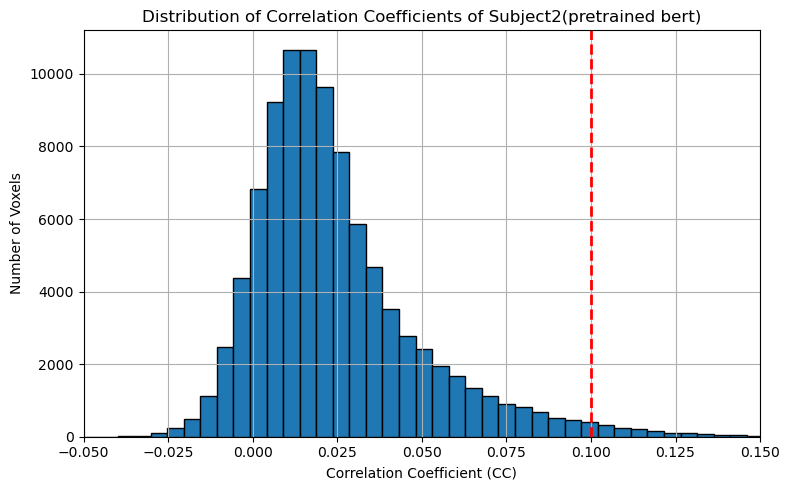

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(valid_ccs_s2, bins=50, edgecolor='black')
plt.title('Distribution of Correlation Coefficients of Subject2(pretrained bert)')
plt.xlabel('Correlation Coefficient (CC)')
plt.ylabel('Number of Voxels')
plt.grid(True)
plt.xlim(-0.05, 0.15)
plt.axvline(x=0.1, color='red', linestyle='--', linewidth=2)
#plt.savefig("../figs/ccdist_pretrainbert_2.png", dpi=300)
plt.tight_layout()
plt.show()

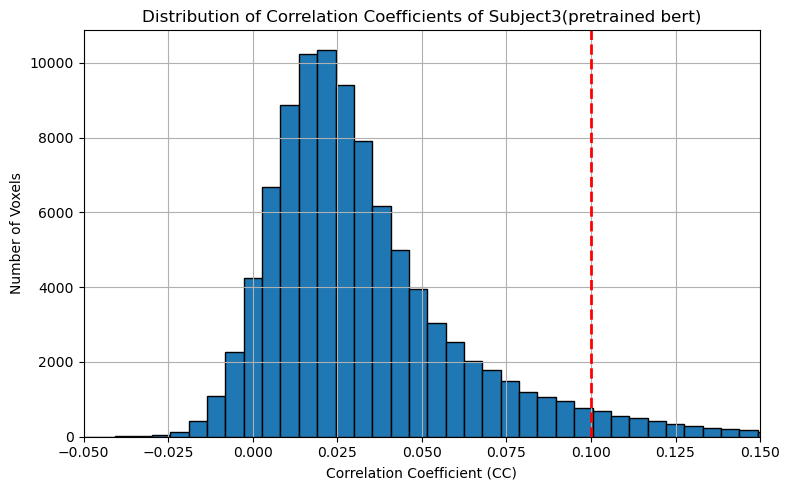

In [23]:
plt.figure(figsize=(8, 5))
plt.hist(valid_ccs_s3, bins=50, edgecolor='black')
plt.title('Distribution of Correlation Coefficients of Subject3(pretrained bert)')
plt.xlabel('Correlation Coefficient (CC)')
plt.ylabel('Number of Voxels')
plt.grid(True)
plt.xlim(-0.05, 0.15)
plt.axvline(x=0.1, color='red', linestyle='--', linewidth=2)
#plt.savefig("../figs/ccdist_pretrainbert_3.png", dpi=300)
plt.tight_layout()
plt.show()

Part 2. 

Now that we identified the best alphas, we will investigat the distribution of CCs for certain test stories and see which voxels perform the best for that story. 

 We will first use the first test story which is 'avatar'.

In [24]:
test_stories[0]

'avatar'

**subject2**

In [25]:
#use first test story
Y_test_story = np.load(path_s2 + "avatar.npy")
Y_test_story = zs(Y_test_story)
X_test_story = delayed_vectors_bert_test['avatar']
X_test_story = zs(X_test_story)

For the alphas, we will still use the best alphas that we got from 5-fold CV previously. 

In [26]:
corr_avatar = ridge_corr_pred(X_train_full, X_test_story, Y_train_s2, Y_test_story, valphas= valphas_s2, use_corr=True)
mean_cc_avatar = np.mean(corr_avatar[np.isfinite(corr_avatar)]) #exclude
print("Mean CC for avatar:", mean_cc_avatar)

# Compute statistics for subject 3
valid_ccs_avatar = corr_avatar[np.isfinite(corr_avatar)]  # Exclude NaNs/infs
mean_cc_avatar = np.mean(valid_ccs_avatar)
median_cc_avatar = np.median(valid_ccs_avatar)
top_1_percentile_cc_avatar = np.percentile(valid_ccs_avatar, 99)  # Top 1 percentile
top_5_percentile_cc_avatar = np.percentile(valid_ccs_avatar, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 2, avatar (bert): {mean_cc_avatar}")
print(f"Median test CC for subject 2, avatar (bert): {median_cc_avatar}")
print(f"Top 1 percentile test CC for subject 2,avatar (bert): {top_1_percentile_cc_avatar}")
print(f"Top 5 percentile test CC for subject 2,avatar (bert): {top_5_percentile_cc_avatar}")

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23810, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2306.696
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000


Mean CC for avatar: 0.021542138539902826
Mean test CC for subject 2, avatar (bert): 0.021542138539902826
Median test CC for subject 2, avatar (bert): 0.016505357937065427
Top 1 percentile test CC for subject 2,avatar (bert): 0.25491541920348487
Top 5 percentile test CC for subject 2,avatar (bert): 0.15753742054494588


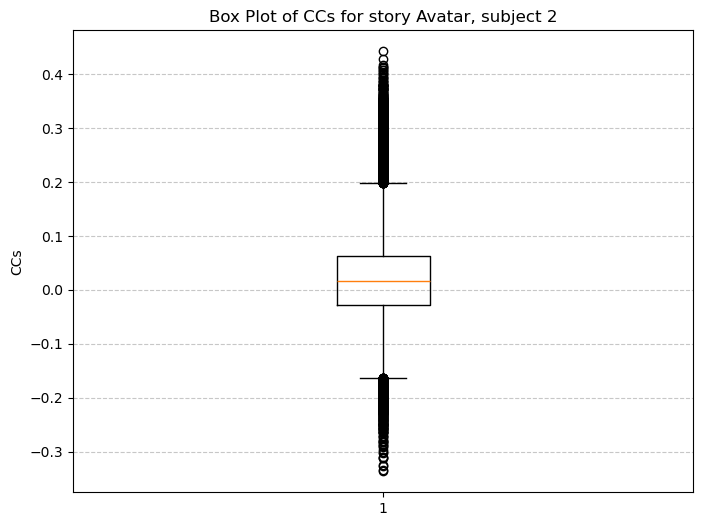

In [27]:
#Plot the CC distribution for Avatar
plt.figure(figsize=(8, 6))
plt.boxplot(valid_ccs_avatar)
plt.title("Box Plot of CCs for story Avatar, subject 2")
plt.ylabel("CCs")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**subject 3**

In [28]:
Y_test_story = np.load(path_s3 + "avatar.npy")
Y_test_story = zs(Y_test_story)

In [29]:
corr_avatar = ridge_corr_pred(X_train_full, X_test_story, Y_train_s3, Y_test_story, valphas= valphas_s3, use_corr=True)
mean_cc_avatar = np.mean(corr_avatar[np.isfinite(corr_avatar)]) #exclude

# Compute statistics for subject 3
valid_ccs_avatar = corr_avatar[np.isfinite(corr_avatar)]  # Exclude NaNs/infs
mean_cc_avatar = np.mean(valid_ccs_avatar)
median_cc_avatar = np.median(valid_ccs_avatar)
top_1_percentile_cc_avatar = np.percentile(valid_ccs_avatar, 99)  # Top 1 percentile
top_5_percentile_cc_avatar = np.percentile(valid_ccs_avatar, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 3, avatar (bert): {mean_cc_avatar}")
print(f"Median test CC for subject 3, avatar (bert): {median_cc_avatar}")
print(f"Top 1 percentile test CC for subject 3,avatar (bert): {top_1_percentile_cc_avatar}")
print(f"Top 5 percentile test CC for subject 3,avatar (bert): {top_5_percentile_cc_avatar}")

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23810, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2306.696
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000


Mean test CC for subject 3, avatar (bert): 0.011682416790516088
Median test CC for subject 3, avatar (bert): 0.009511298904084664
Top 1 percentile test CC for subject 3,avatar (bert): 0.19207013298962072
Top 5 percentile test CC for subject 3,avatar (bert): 0.12860517424661386


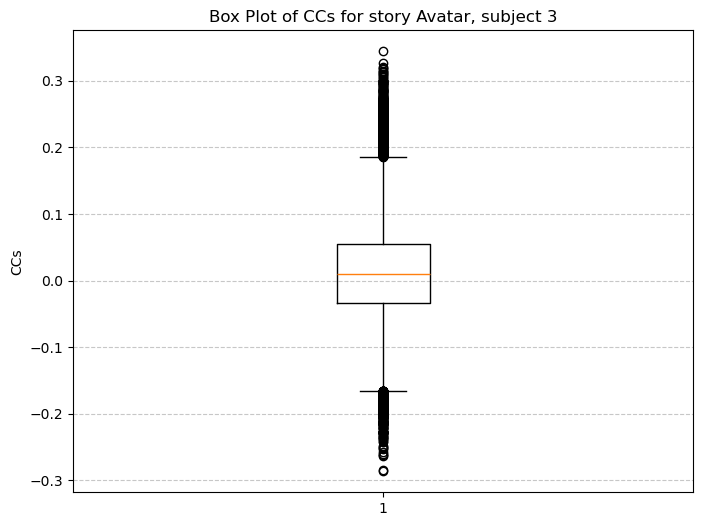

In [30]:
#Plot the CC distribution for Avatar
plt.figure(figsize=(8, 6))
plt.boxplot(valid_ccs_avatar)
plt.title("Box Plot of CCs for story Avatar, subject 3")
plt.ylabel("CCs")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 3.3 part b)

In [31]:
'''
Add this part when running for the first time

'''

#!pip install lime
#!pip install shap
#!pip install --upgrade tokenizers numba cloudpickle

'\nAdd this part when running for the first time\n\n'

In [32]:
import numpy as np
import shap
from lime.lime_text import LimeTextExplainer
from sklearn.linear_model import Ridge

In [33]:

PATH_S2 = '/ocean/projects/mth240012p/shared/data/subject2'
zs = lambda V: (V - V.mean(0)) / V.std(0)

In [34]:
def get_good_voxels(corrs, percentile=95):
    """Return (good_voxel_indices, threshold_value)."""
    valid = np.isfinite(corrs)
    thr   = np.percentile(corrs[valid], percentile)
    return np.where(corrs >= thr)[0], thr

def fit_ridge_models(X_train, Y_train, valphas, voxels):
    """Fit one Ridge per voxel, return dict {v: model}."""
    models = {}
    for v in voxels:
        m = Ridge(alpha=valphas[v]).fit(X_train, Y_train[:, v])
        models[v] = m
    return models

def make_text_to_features(story):
    """Return a function that maps a word-list → delayed, z-scored features."""
    def text_to_features(words):
        emb  = make_word_embeddings(words)
        down = downsample_word_vectors(
            [story], {story:emb}, {story:raw_text[story]}
        )[story]
        Xd = make_delayed(down, delays=[1,2,3,4])
        return zs(Xd)
    return text_to_features

def make_predict_fn(ridge_model, text_to_features_fn):
    """Return a function texts(list of str) → predictions array."""
    def predict_fn(texts):
        preds = []
        for t in texts:
            feats = text_to_features_fn(t.split())
            seg   = feats.mean(axis=0).reshape(1, -1)
            preds.append(ridge_model.predict(seg)[0])
        return np.array(preds)
    return predict_fn

In [35]:
# def interpret_story(story, top_percentile=95, top_voxels=3):
#     """
#     For one story:
#       - compute CCs
#       - pick top-percentile voxels
#       - fit ridges
#       - run SHAP & LIME on the first `top_voxels` of them
#     """
#     print(f"\n=== Interpreting story: {story} ===")
#     # load and z-score test-set for this story
#     X_ts = zs(delayed_vectors_bert_test[story])
#     Y_ts = zs(np.load(f"{PATH_S2}/{story}.npy"))

#     # we compute CCs and pick goood voxels
#     corrs = ridge_corr_pred(
#         X_train_full, X_ts, Y_train_s2, Y_ts,
#         valphas=valphas_s2, use_corr=True
#     )
#     good_voxels, thr = get_good_voxels(corrs, percentile=top_percentile)
#     print(f"  {len(good_voxels)} voxels ≥{top_percentile}th pct (CC ≥{thr:.3f})")

#     # now, we fit one Ridge per “good” voxel
#     ridge_models = fit_ridge_models(X_train_full, Y_train_s2, valphas_s2, good_voxels)

#     # then we build text -> features once for this story
#     text2feat = make_text_to_features(story)

#     # for the first few voxels, we run SHAP+LIME
#     for v in good_voxels[:top_voxels]:
#         print(f"-- Voxel {v}: SHAP & LIME")

#         # SHAP here
#         explainer = shap.Explainer(
#             make_predict_fn(ridge_models[v], text2feat),
#             tokenizer=lambda x: x.split()
#         )
#         sv = explainer([ " ".join(raw_text[story]) ])[0]
#         shap.plots.text(sv, display=True, max_display=10)

#         # LIME here
#         lime_exp = LimeTextExplainer(split_expression=lambda x: x.split())
#         exp      = lime_exp.explain_instance(
#             " ".join(raw_text[story]),
#             make_predict_fn(ridge_models[v], text2feat),
#             num_features=10
#         )
#         fig = exp.as_pyplot_figure()
#         fig.suptitle(f"LIME: story={story}, voxel={v}")
#         plt.show()


In [36]:
# for s in test_stories[:2]:
#     interpret_story(s, top_percentile=95, top_voxels=2)

In [37]:
# from joblib import Parallel, delayed

In [38]:
# def interpret_story(
#     story,
#     top_percentile=95,
#     top_voxels=3,
#     ridge_n_jobs=8,
#     shap_nsamples=100,
#     shap_n_jobs=4,
#     lime_samples=200
# ):
#     """
#     Optimized interpretability pipeline:
#       - compute CCs
#       - pick top-percentile voxels
#       - fit ridges in parallel
#       - run SHAP & LIME on the first `top_voxels` of them
#     """
#     print(f"\n=== Interpreting story: {story} ===")
#     # 1) load & z-score test‐set
#     X_ts = zs(delayed_vectors_bert_test[story])
#     Y_ts = zs(np.load(f"{PATH_S2}/{story}.npy"))

#     # 2) compute CCs & pick “good” voxels
#     corrs = ridge_corr_pred(
#         X_train_full, X_ts, Y_train_s2, Y_ts,
#         valphas=valphas_s2, use_corr=True
#     )
#     good_voxels, thr = get_good_voxels(corrs, percentile=top_percentile)
#     print(f"  {len(good_voxels)} voxels ≥{top_percentile}th pct (CC ≥{thr:.3f})")

#     # 3) fit Ridges in parallel
#     def _fit_one(v):
#         return v, Ridge(alpha=valphas_s2[v], solver='lsqr').fit(
#             X_train_full, Y_train_s2[:, v]
#         )

#     fits = Parallel(n_jobs=ridge_n_jobs)(
#         delayed(_fit_one)(v) for v in good_voxels
#     )
#     ridge_models = {v: model for v, model in fits}

#     # 4) build text->features once
#     text2feat = make_text_to_features(story)

#     # 5) precompute joined text
#     story_text = " ".join(raw_text[story])

#     # 6) build predict_fns ahead of time
#     predict_fns = {
#         v: make_predict_fn(ridge_models[v], text2feat)
#         for v in good_voxels[:top_voxels]
#     }

#     # 7) run SHAP & LIME on the first top_voxels
#     for v in good_voxels[:top_voxels]:
#         print(f"-- Voxel {v}: SHAP & LIME")

#         # 7a) SHAP
#         explainer = shap.Explainer(
#             predict_fns[v],
#             masker=shap.maskers.Text(split_expression=lambda x: x.split()),
#             nsamples=shap_nsamples,
#             n_jobs=shap_n_jobs
#         )
#         sv = explainer([story_text])[0]
#         shap.plots.text(sv, max_display=10)
        
#         # 7b) LIME
#         lime_exp = LimeTextExplainer(
#             split_expression=lambda x: x.split(),
#             kernel_width=25.0
#         )
#         exp = lime_exp.explain_instance(
#             story_text,
#             predict_fns[v],
#             num_samples=lime_samples,
#             num_features=10
#         )
#         fig = exp.as_pyplot_figure()
#         fig.suptitle(f"LIME: story={story}, voxel={v}")
#         plt.show()


In [39]:
# # Example: run only 2 voxels, lighter sampling
# interpret_story(
#     "avatar",
#     top_percentile=95,
#     top_voxels=2,
#     ridge_n_jobs=4,
#     shap_nsamples=50,
#     shap_n_jobs=2,
#     lime_samples=100
# )


In [40]:
## PArt b)

import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.linear_model import Ridge
import numpy as np
import matplotlib.pyplot as plt


In [41]:
# User paraemteres
N_STORIES = 2   # how many test stories to explain
N_VOXELS  = 4   # how many top voxels per story
MAX_EVALS = 6145  # same as your teammate

In [42]:
#we pick “good” voxels once, as before
threshold   = np.percentile(final_ccs_s2[np.isfinite(final_ccs_s2)], 95)
good_voxels = np.where(final_ccs_s2 >= threshold)[0][:N_VOXELS]
print(f"Top {N_VOXELS} voxels ≥95th pct:", good_voxels.tolist())

Top 4 voxels ≥95th pct: [520, 540, 554, 555]


In [43]:
# we fit a Ridge per voxel, as before
# ridge_models = {}
# for v in good_voxels:
#     r = Ridge(alpha=valphas_s2[v])
#     r.fit(X_train_full, Y_train_s2[:, v])
#     ridge_models[v] = r

# we only need the top voxels
ridge_models = {}
for v in good_voxels:
    mdl = Ridge(alpha=valphas_s2[v]).fit(X_train_full, Y_train_s2[:, v])
    ridge_models[v] = mdl

In [44]:
# Helper functions
def make_predict_fn(voxel, story):
    def predict_fn(X):
        # X is a (n_samples, n_features) matrix of delayed embeddings
        return X @ ridge_models[voxel].coef_.reshape(-1,1)
    return predict_fn


=== Story: avatar ===
-- Voxel 520: SHAP waterfall + LIME


PermutationExplainer explainer: 101it [16:20,  9.81s/it]                         


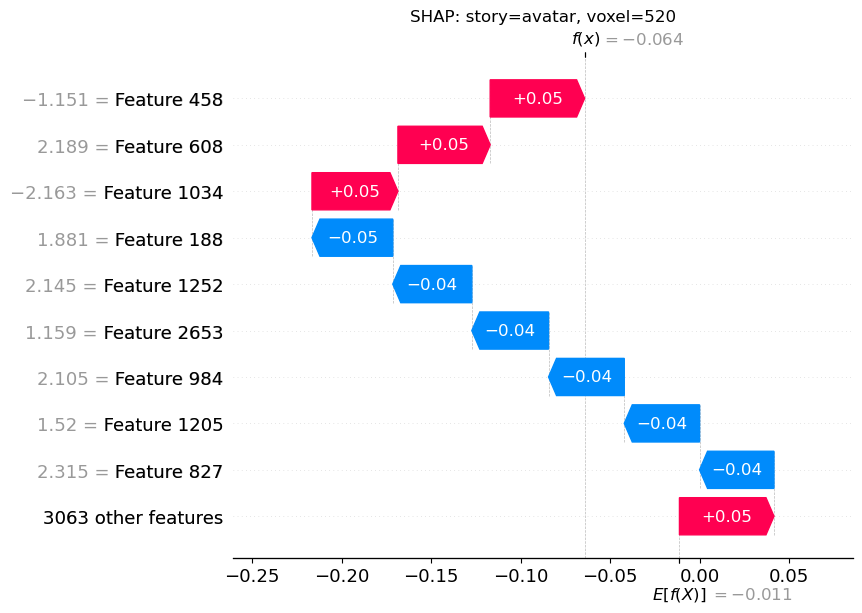

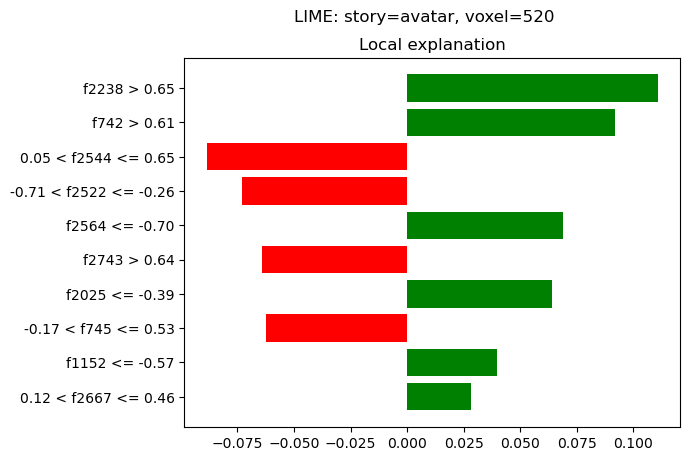

-- Voxel 540: SHAP waterfall + LIME


PermutationExplainer explainer: 101it [16:25,  9.95s/it]                         


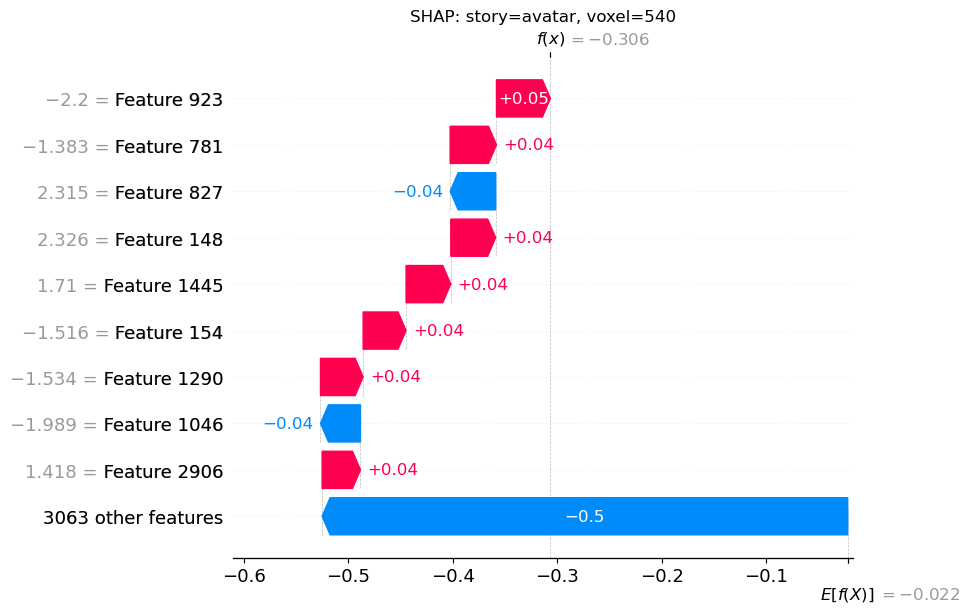

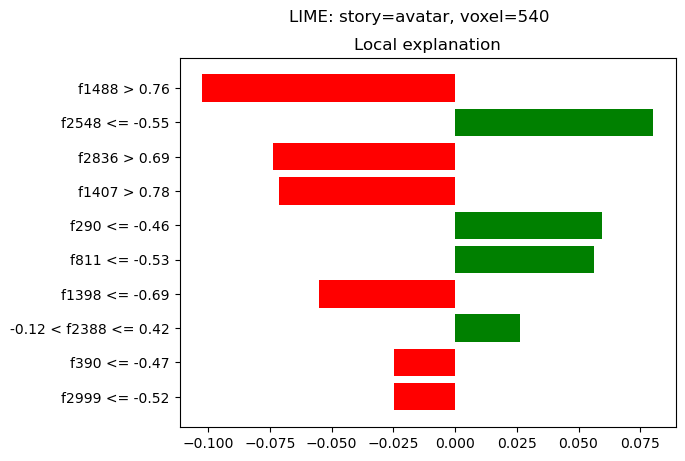

-- Voxel 554: SHAP waterfall + LIME


PermutationExplainer explainer: 101it [17:06, 10.37s/it]                         


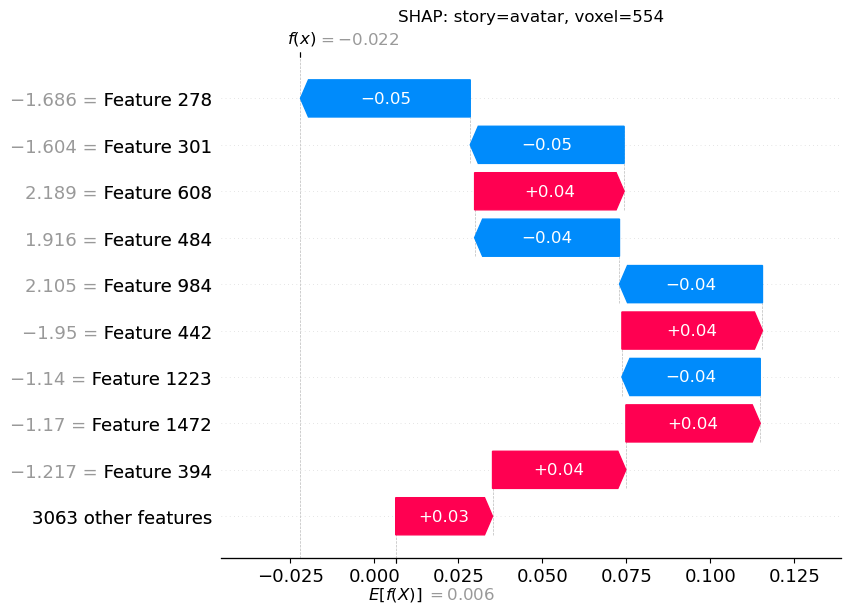

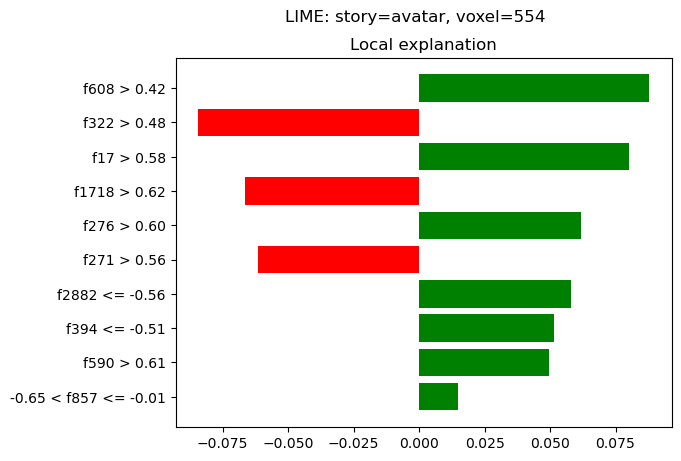

-- Voxel 555: SHAP waterfall + LIME


PermutationExplainer explainer: 101it [16:50, 10.20s/it]                         


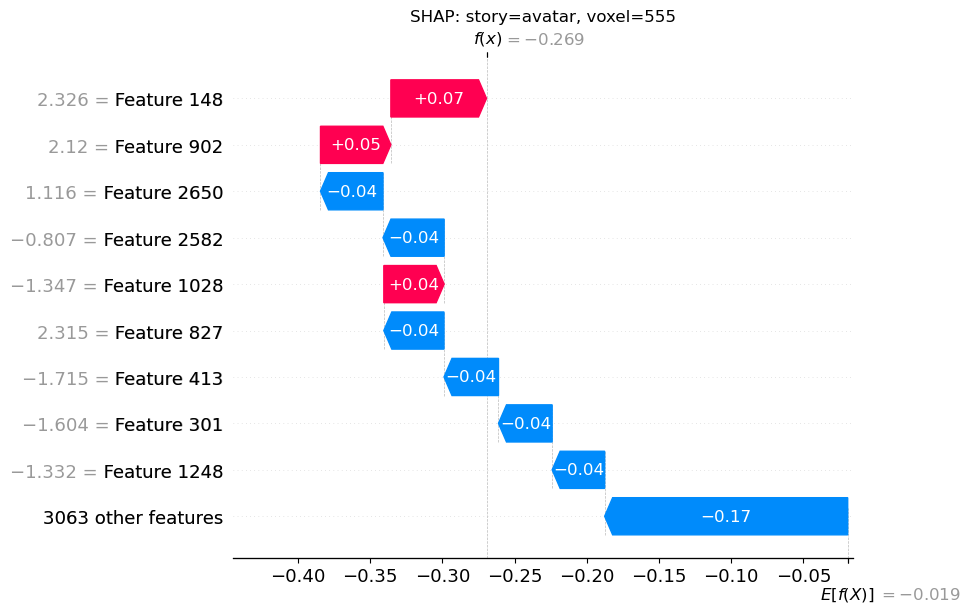

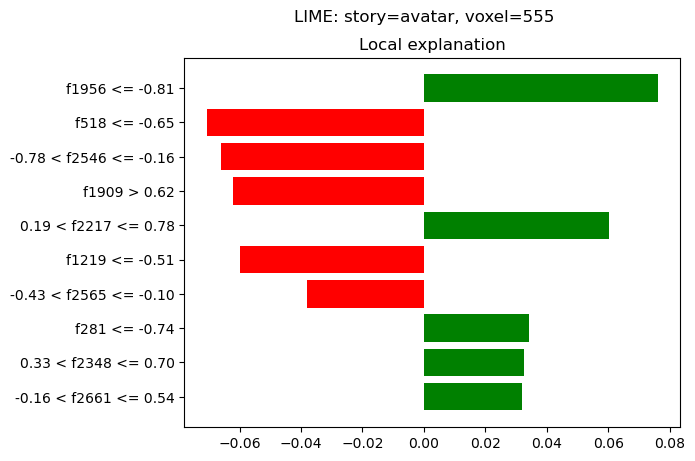


=== Story: backsideofthestorm ===
-- Voxel 520: SHAP waterfall + LIME


PermutationExplainer explainer: 101it [17:07, 10.38s/it]                         


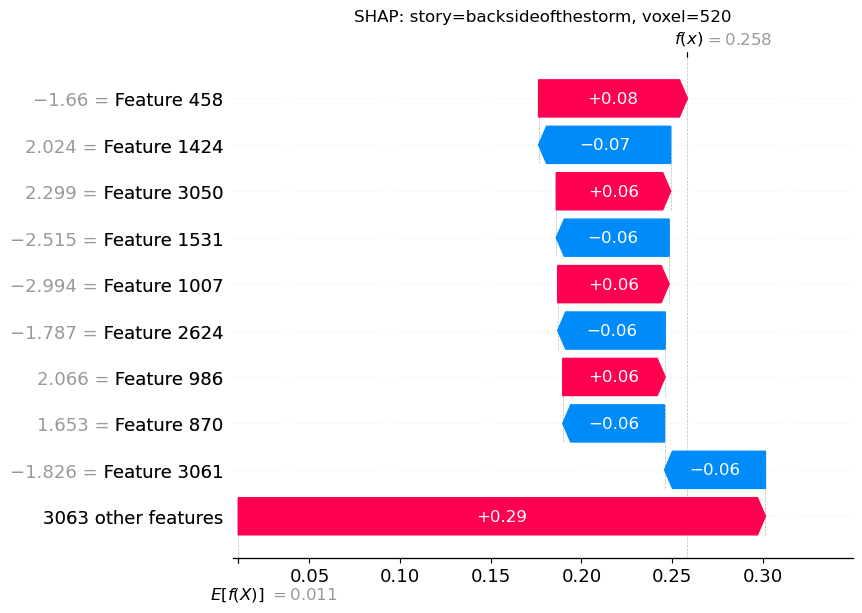

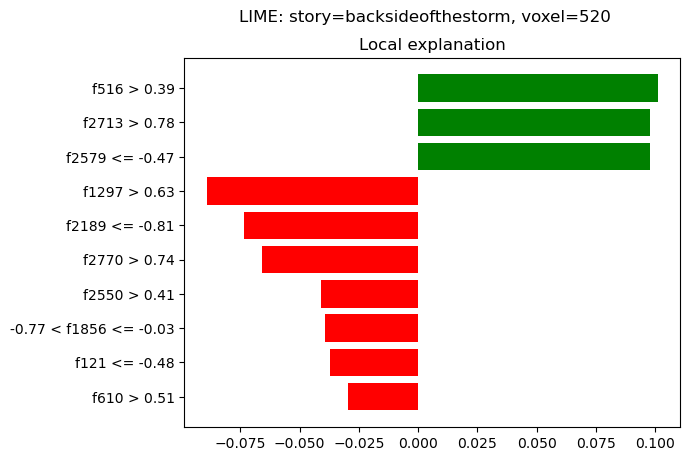

-- Voxel 540: SHAP waterfall + LIME


PermutationExplainer explainer: 101it [17:12, 10.43s/it]                         


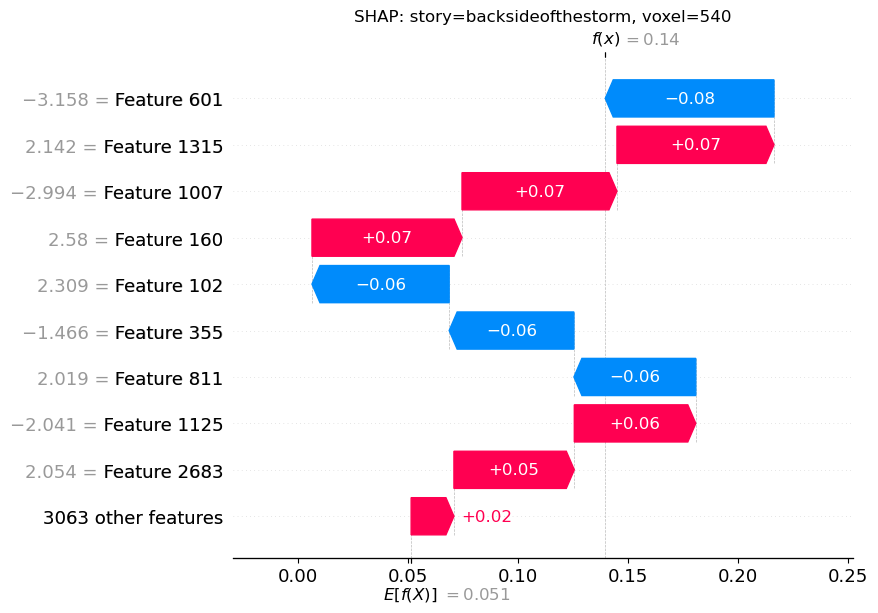

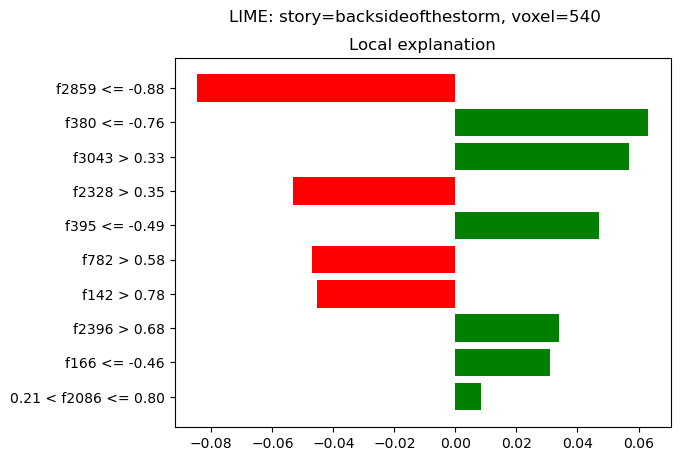

-- Voxel 554: SHAP waterfall + LIME


PermutationExplainer explainer: 101it [16:53, 10.24s/it]                         


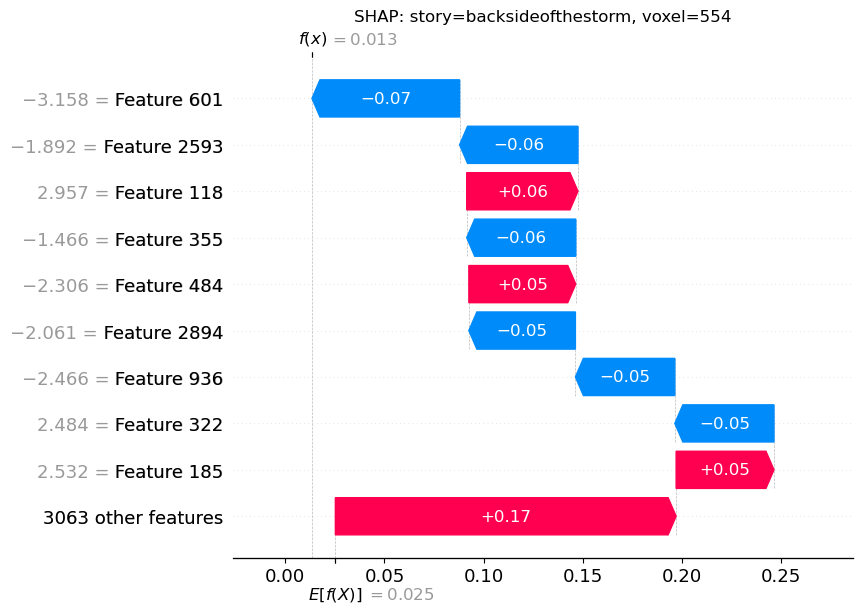

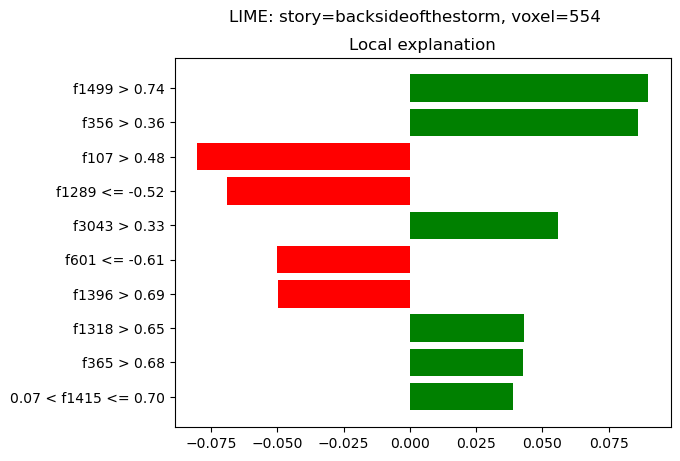

-- Voxel 555: SHAP waterfall + LIME


PermutationExplainer explainer: 101it [17:07, 10.38s/it]                         


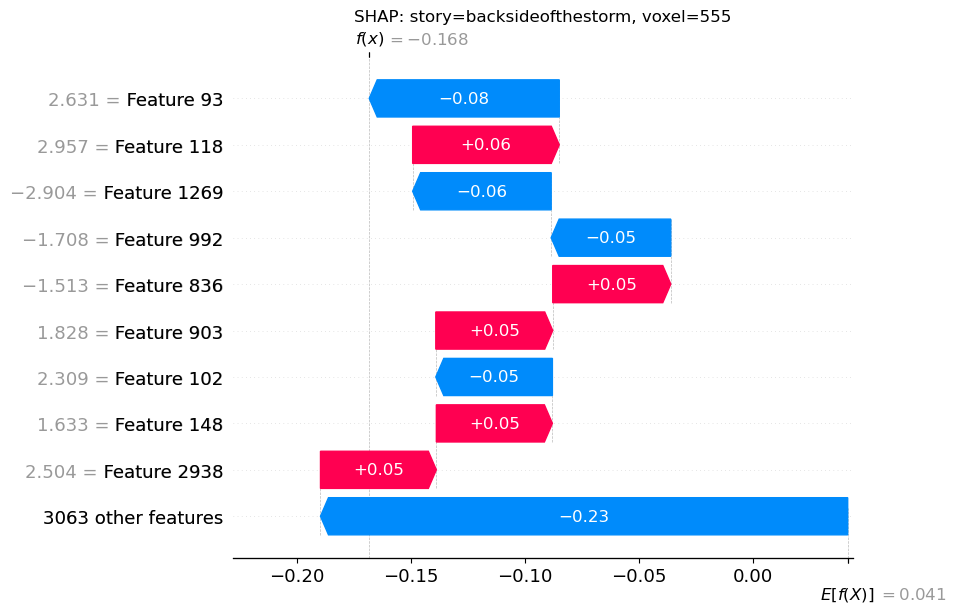

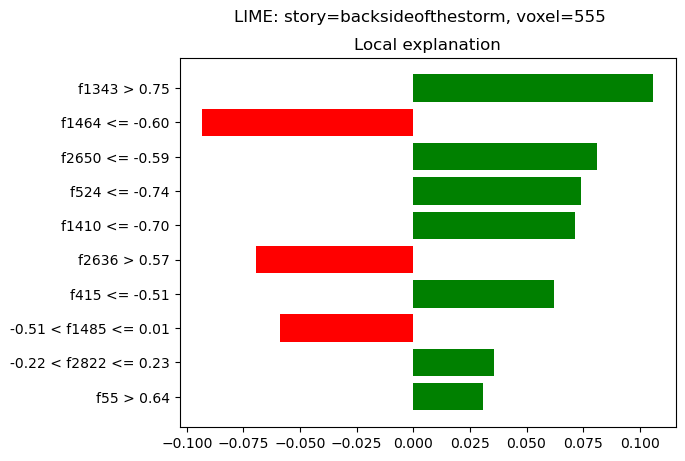

In [45]:
for story in test_stories[:N_STORIES]:
    print(f"\n=== Story: {story} ===")
    X_test_story = zs(delayed_vectors_bert_test[story])     # already pre‐z‐scored
    Y_test_story = zs(np.load(f"{PATH_S2}/{story}.npy"))

    # sample 100 random timepoints for your “background” 
    idx         = np.random.choice(X_test_story.shape[0], 100, replace=False)
    X_sample    = X_test_story[idx]

    for v in good_voxels:
        print(f"-- Voxel {v}: SHAP waterfall + LIME")

        # ——— SHAP waterfall (tabular) ——————————————————————————————————
        explainer  = shap.Explainer(make_predict_fn(v, story), X_sample)
        shap_vals  = explainer(X_sample, max_evals=MAX_EVALS)
        shap.plots.waterfall(shap_vals[0], show=False)  # prevents auto-display
        plt.title(f"SHAP: story={story}, voxel={v}")
        #plt.savefig(f"plots/shap_story{story}_voxel{v}.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # ——— LIME tabular ————————————————————————————————————————
        lime_exp   = LimeTabularExplainer(
            training_data=X_sample,
            mode="regression",
            feature_names=[f"f{i}" for i in range(X_sample.shape[1])],
            discretize_continuous=True,
            verbose=False
        )
        i          = 0  # explain the first sample in X_sample
        exp        = lime_exp.explain_instance(
                         data_row=X_sample[i],
                         predict_fn=make_predict_fn(v, story),
                         num_features=10
                     )
        fig = exp.as_pyplot_figure()
        fig.suptitle(f"LIME: story={story}, voxel={v}")
        #fig.savefig(f"plots/lime_story{story}_voxel{v}.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)